# Sanity test

In [1]:
import sys
sys.path.append("../../..")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from umap import UMAP
#from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error 

from librep.datasets.har.loaders import MotionSense_BalancedView20HZ
from librep.datasets.multimodal import TransformMultiModalDataset, WindowedTransform
from librep.transforms.fft import FFT
from librep.transforms.filter import ButterWorthFilter
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier, SVC, KNeighborsClassifier
from librep.metrics.report import ClassificationReport

2022-10-31 14:32:02.244207: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-31 14:32:02.244234: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
loader = MotionSense_BalancedView20HZ("../../../data_2/views/MotionSense/balanced_20Hz_filtered", 
                                   download=False) 
data_filtered = loader.load(concat_all=True, label="standard activity code")
data_filtered

PandasMultiModalDataset: samples=5028, features=360, no. window=6, label_columns='standard activity code'

In [4]:
loader = MotionSense_BalancedView20HZ("../../../data_2/views/MotionSense/balanced_20Hz_without_gravity", 
                                   download=False) 
data_no_gravity = loader.load(concat_all=True, label="standard activity code")
data_no_gravity

PandasMultiModalDataset: samples=5028, features=360, no. window=6, label_columns='standard activity code'

In [5]:
loader = MotionSense_BalancedView20HZ("../../../data_2/views/MotionSense/balanced_20Hz_with_gravity", 
                                   download=False) 
data_gravity = loader.load(concat_all=True, label="standard activity code")
data_gravity

PandasMultiModalDataset: samples=5028, features=360, no. window=6, label_columns='standard activity code'

# Plot de amostras

In [48]:
data_no_gravity.data.iloc[:,540:-6]

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,accel-z-50,accel-z-51,accel-z-52,accel-z-53,accel-z-54,accel-z-55,accel-z-56,accel-z-57,accel-z-58,accel-z-59
0,2.241182,2.728428,3.396804,-0.952338,-1.270648,-1.804371,1.001855,2.227502,-0.344117,-0.876607,...,-1.283363,-0.740917,-2.365176,2.563242,2.028096,2.338457,2.712017,5.126192,-3.308867,-1.663984
1,3.883921,1.704150,-3.228425,-2.962008,-2.153505,0.538136,1.358778,2.383544,0.793882,-2.705088,...,-4.356378,-6.146229,-1.574884,1.945857,0.797580,1.146240,1.793787,1.608346,0.095222,-0.051034
2,0.504353,-1.575025,3.797335,-3.595398,-7.265575,-3.041922,1.849816,-2.058225,-2.053070,-1.429679,...,-3.517776,-1.391578,1.191999,0.683895,-1.852043,-1.720781,0.356853,1.013483,0.490549,5.155687
3,-0.048582,1.847707,-0.797207,0.955127,3.320153,-1.181281,2.072347,0.809453,1.343515,0.028021,...,-1.063796,-1.374023,-1.439408,-1.985817,-2.501898,-1.693788,-4.201165,-0.218421,-0.913303,-2.993954
4,1.738493,-0.776014,-2.813108,-3.070826,-1.443581,3.411237,0.836343,2.344305,4.200099,-0.746680,...,3.093705,1.701772,-2.745204,4.361438,-1.397233,-0.019876,-3.875074,3.139071,2.375816,2.340997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5023,1.229652,3.273590,0.795043,8.451653,7.285570,-1.700821,2.379763,-0.442292,3.437822,-0.087031,...,1.862584,1.391823,5.416033,9.304215,-2.585571,-5.028007,5.940004,6.213244,0.679169,-5.131871
5024,0.649214,1.476657,5.587020,-1.936038,0.535497,-7.897102,7.882700,-3.454315,-0.332340,-8.909386,...,3.607168,5.801685,-6.414830,3.451078,12.422158,14.207994,-12.381934,7.677811,-0.169483,4.894647
5025,0.471196,0.730347,-9.547672,0.448438,2.080617,-0.905029,0.972964,1.209240,-6.693453,-5.028750,...,0.448407,-11.683926,7.022427,10.885024,13.697942,-11.884998,-11.738040,-11.542589,-6.715729,-8.820428
5026,1.874669,0.951728,-0.185146,0.550318,-4.778107,2.917659,-0.018703,-2.513947,-3.151960,-0.876959,...,-4.282069,-4.757201,21.497997,5.864611,-9.778836,6.847781,-6.002221,2.057076,-12.224838,-3.564278


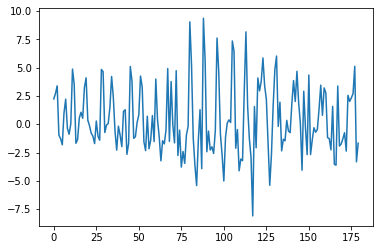

In [49]:
sample = np.array(data_no_gravity.data.iloc[:,540:-6])[0]
plt.plot(sample)

Amostra = 11 Atividade = stair down


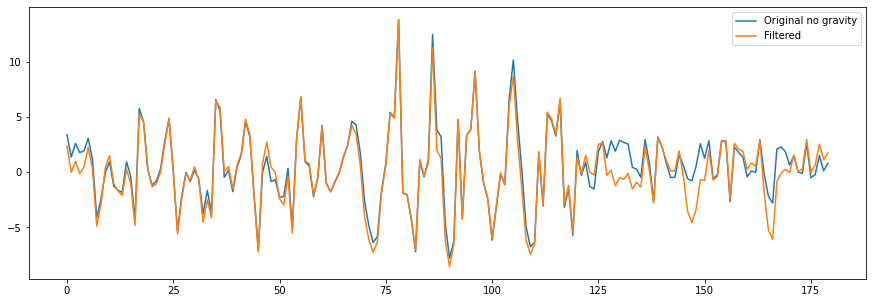

In [50]:
standard_activity_codes = {
    0: "sit",
    1: "stand",
    2: "walk",
    3: "stair up",
    4: "stair down",
    5: "run",
    6: "stair up and down"
}

amostra = 11
# sample = np.array(data_gravity.data.iloc[:,:180])[1]
# plt.plot(sample)
y = np.array(data_filtered.data['standard activity code'])[amostra]
label = standard_activity_codes[y]
print(f"Amostra = {amostra}", f"Atividade = {label}")
plt.figure(figsize=(15,5))
# sample = np.array(data_gravity.data.iloc[:,:180])[amostra]
# plt.plot(sample, label='Gravity')
sample = np.array(data_no_gravity.data.iloc[:,540:-6])[amostra]
plt.plot(sample, label='Original no gravity')
sample = np.array(data_filtered.data.iloc[:,540:-6])[amostra]
plt.plot(sample, label='Filtered')
plt.legend()

In [51]:
def plot_sample(standard_activity_codes, amostra, samples, label):
    
#     print(f"Amostra = {amostra}", f"Atividade = {label}")
    plt.figure(figsize=(15,5))    

#     plt.plot(samples[0], label='Gravity')
    plt.plot(samples[1], label='Original no gravity')
    plt.plot(samples[2], label='Filtered')
    plt.legend()
    plt.title("Amostra = {}  \n Atividade = {}".format(amostra, label))


## Tempo

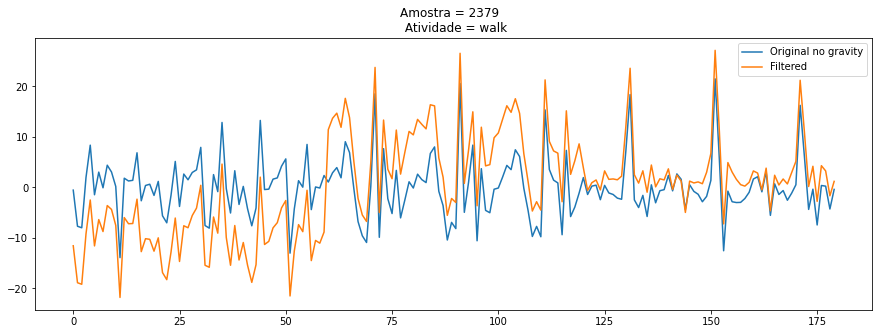

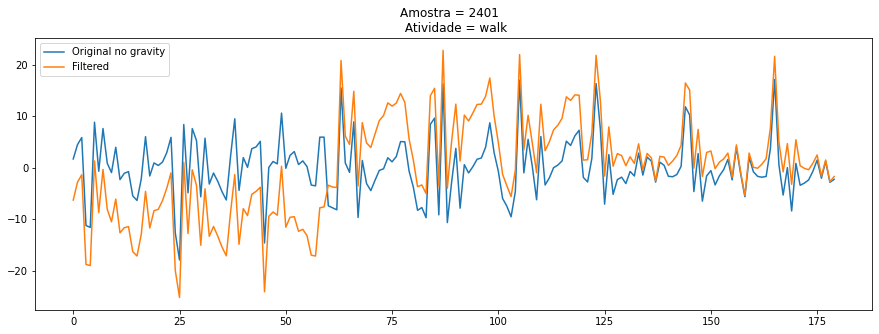

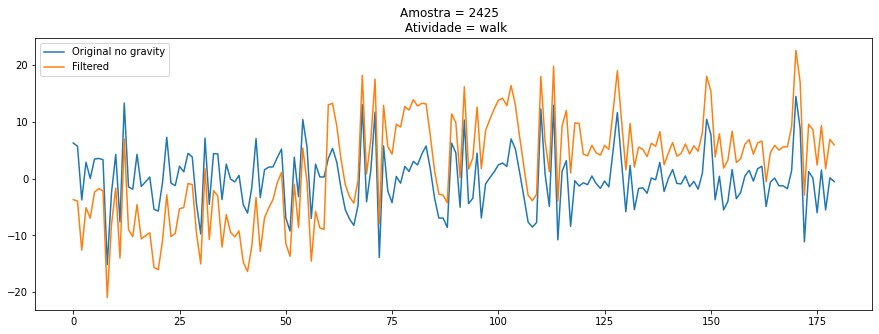

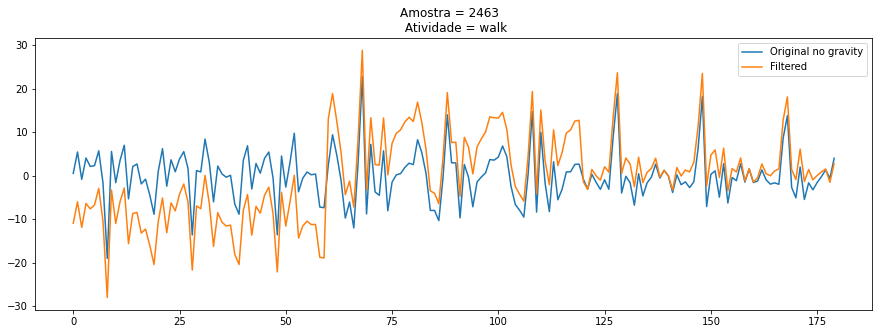

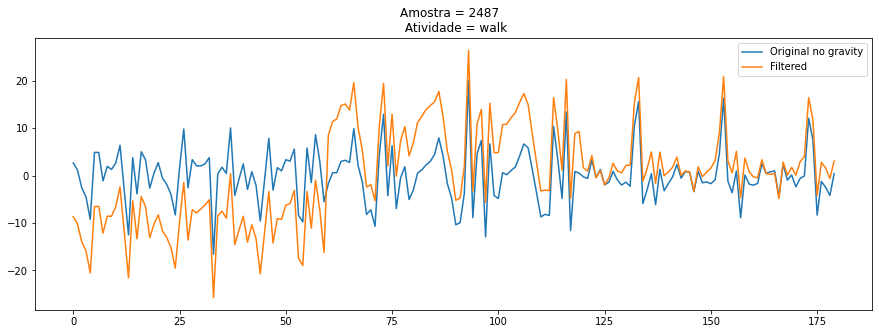

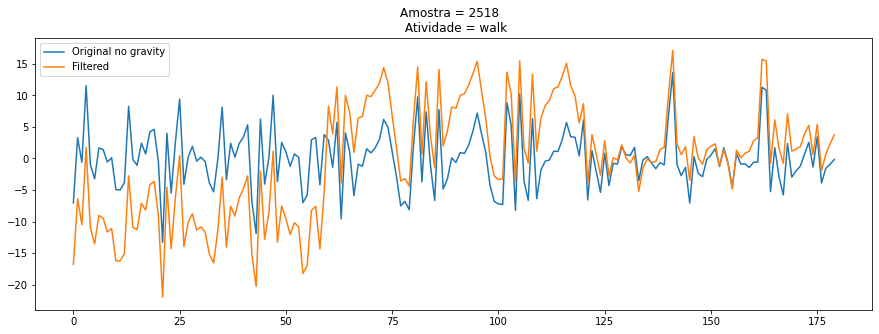

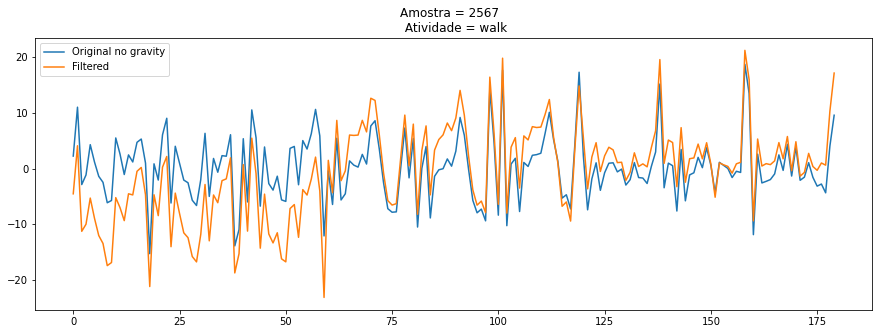

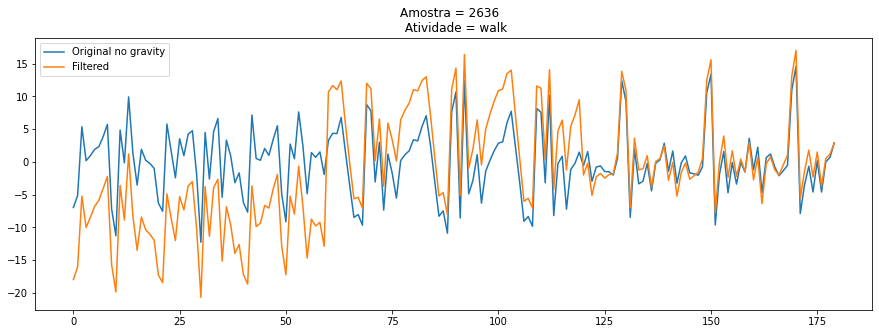

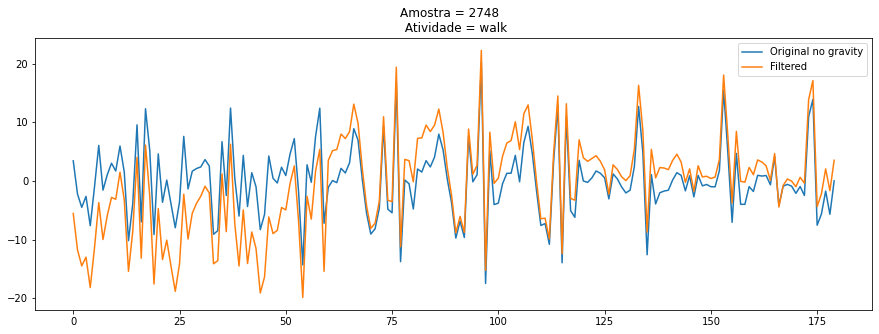

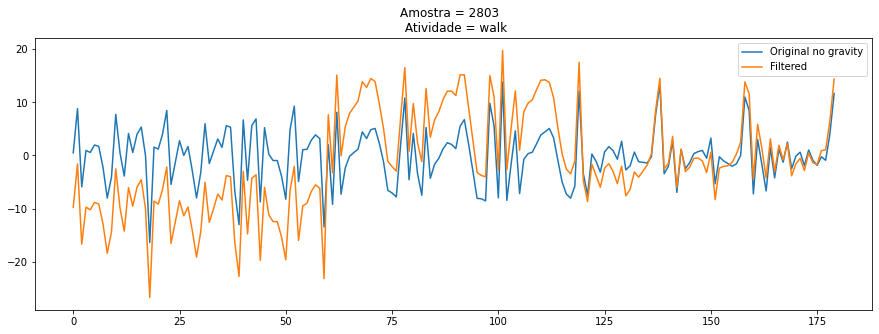

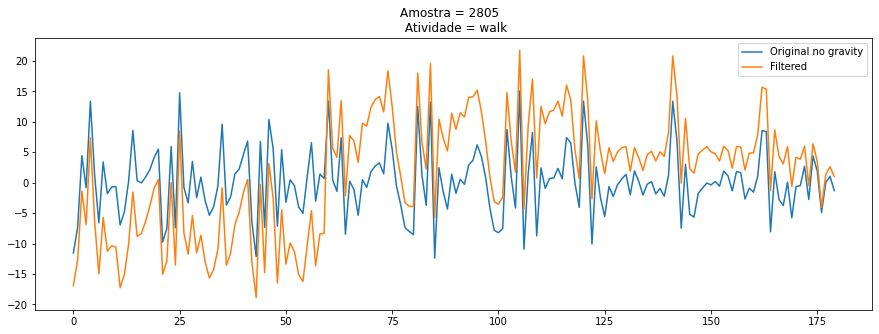

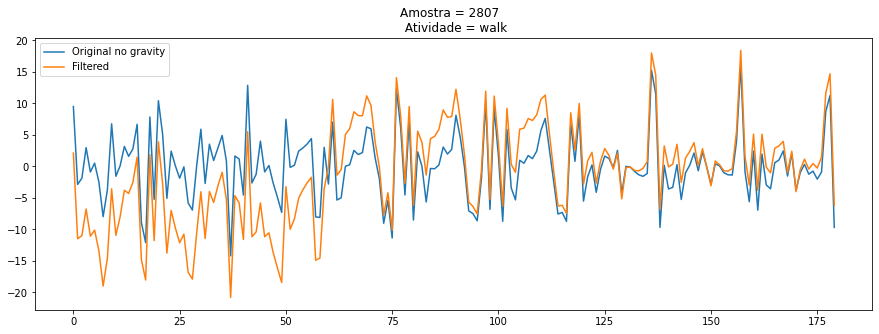

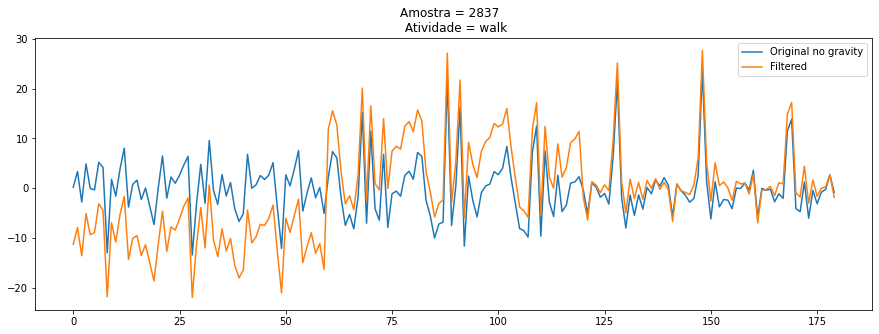

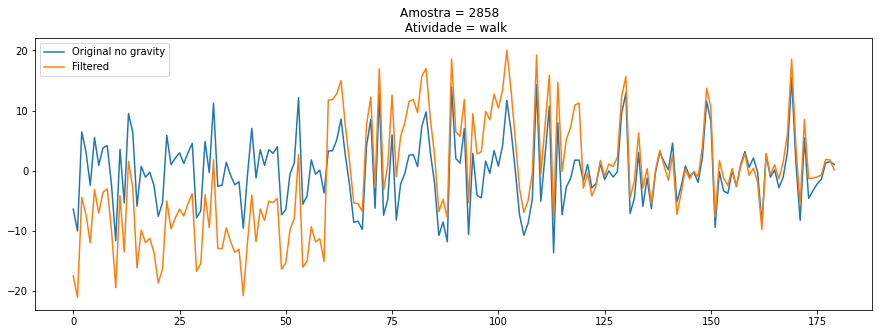

In [52]:
standard_activity_codes = {
    0: "sit",
    1: "stand",
    2: "walk",
    3: "stair up",
    4: "stair down",
    5: "run",
    6: "stair up and down"
}

amostras = [2379, 2401, 2425, 2463, 2487, 2518, 2567, 2636, 2748, 2803, 2805, 2807, 2837, 2858]

for amostra in amostras:
    samples = []
    
    sample = np.array(data_gravity.data.iloc[:,540:-6])[amostra]
    samples.append(sample)    
    
    sample = np.array(data_filtered.data.iloc[:,540:-6])[amostra]
    samples.append(sample)
    
    sample = np.array(data_no_gravity.data.iloc[:,540:-6])[amostra]
    samples.append(sample)
    
    y = np.array(data_filtered.data['standard activity code'])[amostra]
    label = standard_activity_codes[y]
    
    plot_sample(standard_activity_codes, amostra, samples, label)
    

In [53]:
# Create the objects
fft_transform = FFT(centered=True)
# Compose the transform
# First apply the normalizer over whole dataset and then apply FFT over each window
transformer = TransformMultiModalDataset(
    transforms=[fft_transform], new_window_name_prefix="fft."
)

In [54]:
data_gravity_fft = transformer(data_gravity)
data_filtered_fft = transformer(data_filtered)
data_no_gravity_fft = transformer(data_no_gravity)

## Frequência

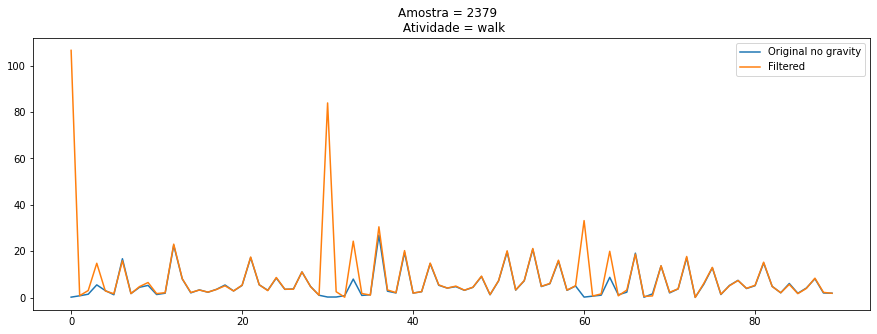

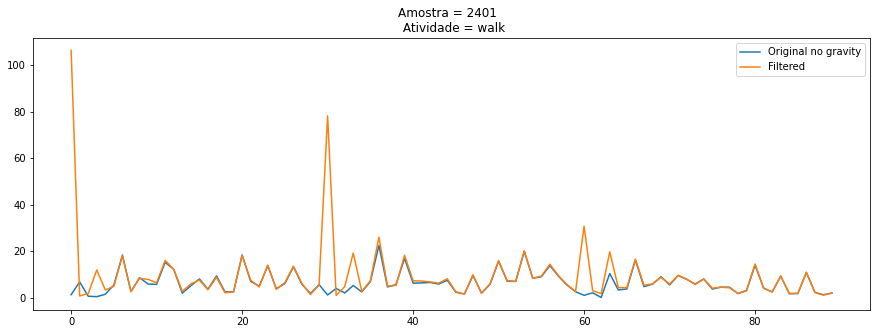

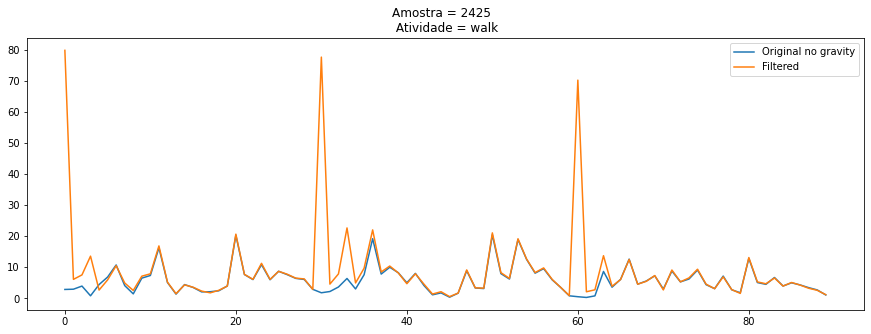

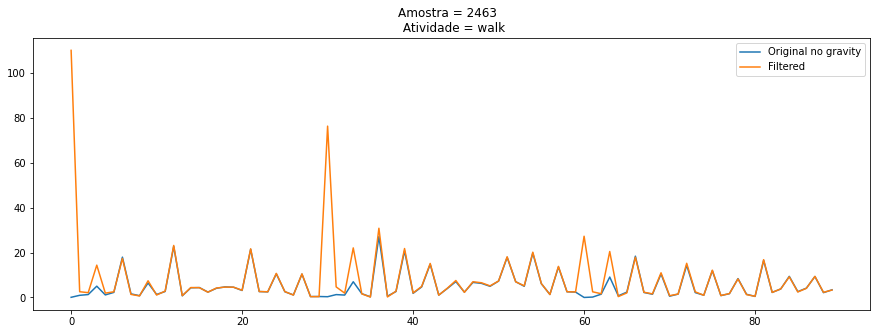

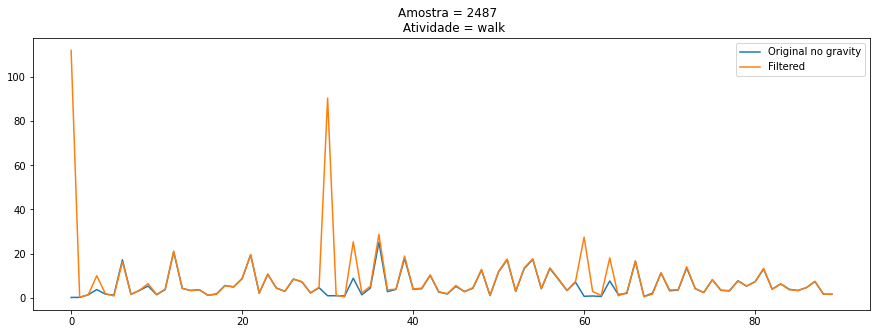

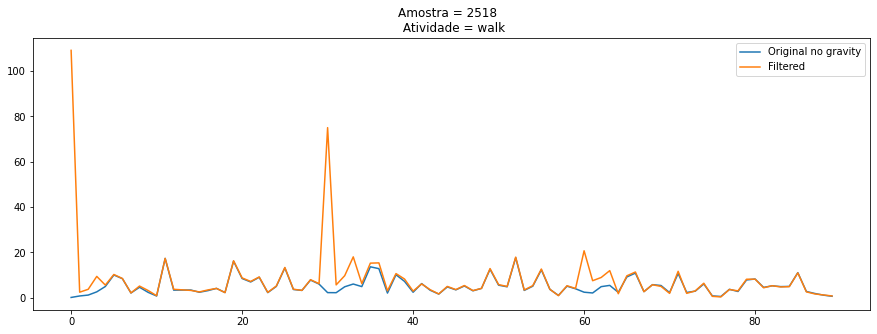

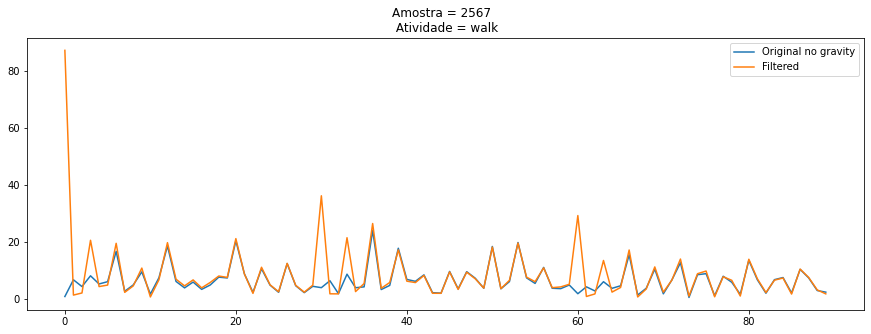

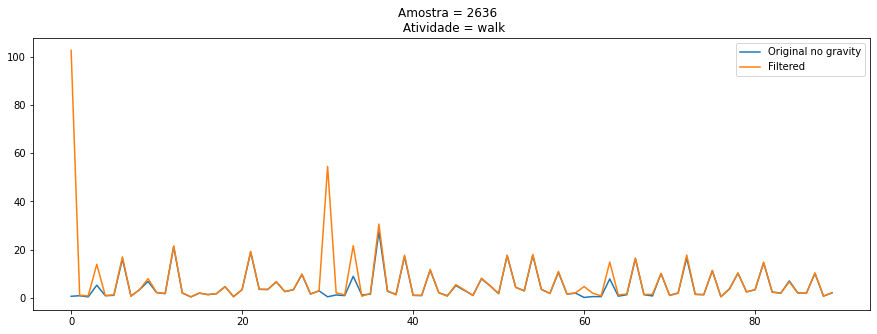

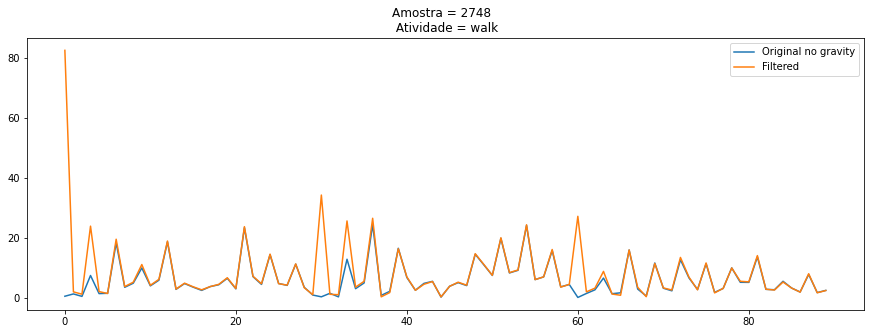

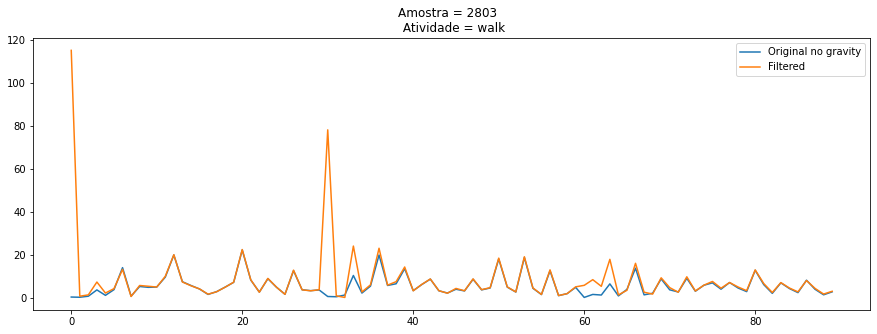

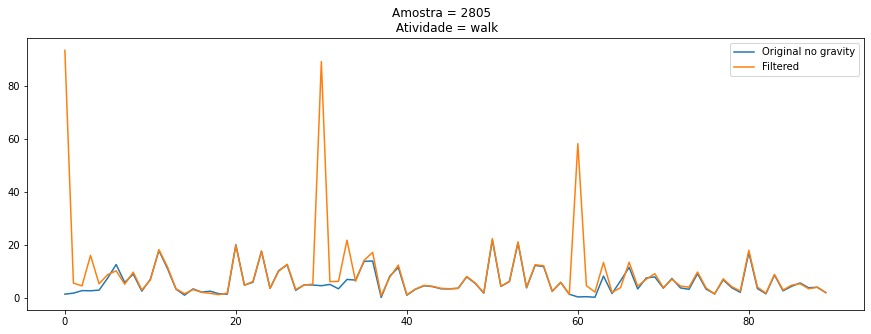

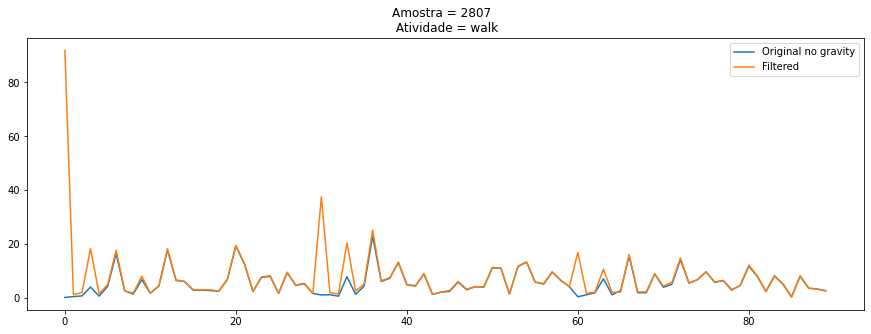

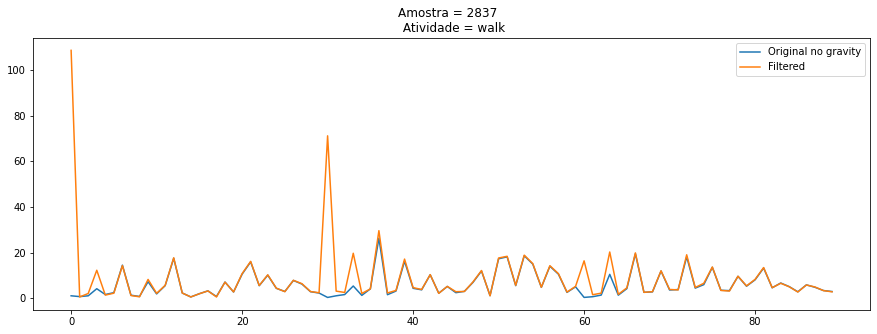

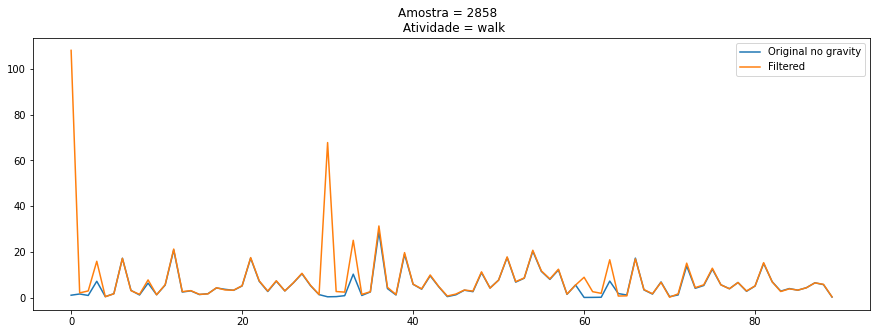

In [55]:
for amostra in amostras:
    samples = []
    
    sample = np.array(data_gravity_fft.X[amostra][:90])
    samples.append(sample)

    sample = np.array(data_filtered_fft.X[amostra][:90])
    samples.append(sample)    
    
    sample = np.array(data_no_gravity_fft.X[amostra][:90])
    samples.append(sample)
    
    
    y = np.array(data_filtered.data['standard activity code'])[amostra]
    label = standard_activity_codes[y]
    
    plot_sample(standard_activity_codes, amostra, samples, label)

In [56]:
data = pd.concat([data_filtered.data, data_no_gravity.data], axis=0)

tam = data.shape[0] // 2
dataset_name = np.array(['Motion_1' for i in range(tam)] + ['Motion_2' for i in range(tam)])
data['DataSet'] = dataset_name
tam = data.shape[0]

In [57]:
from librep.datasets.multimodal import PandasMultiModalDataset # Wrap CSVs to librep's `Dataset` interface

features = [
    "accel-x",
    "accel-y",
    "accel-z",
    "gyro-x",
    "gyro-y",
    "gyro-z"
]

# Creating the datasets

# Train
data_time = PandasMultiModalDataset(
    data,
    feature_prefixes=features,
    label_columns="DataSet",
    as_array=True
)

features = [
    "accel-x",
    "accel-y",
    "accel-z",
    "gyro-x",
    "gyro-y",
    "gyro-z"
]

# Creating the datasets

# Train
data_time_class = PandasMultiModalDataset(
    data,
    feature_prefixes=features,
    label_columns="standard activity code",
    as_array=True
)

# Erro quadrático médio

## Tempo

In [58]:
data_1 = data_filtered.data.iloc[:, 540:-6]
data_2 = data_no_gravity.data.iloc[:, 540:-6]

acc = {'x': [], 'y': [], 'z': []}
axis = ['x', 'y', 'z']

data_1 = np.array(data_1)
data_1 = np.reshape(data_1, (data_filtered.data.shape[0], 3, 60))

data_2 = np.array(data_2)
data_2 = np.reshape(data_2, (data_filtered.data.shape[0], 3, 60))

erro_list = []

for sample_1, sample_2 in zip(data_1, data_2):
    for i in range(3):
        erro = mean_squared_error(sample_1[i], sample_2[i])
        axi = axis[i]
        acc[axi].append(erro)

Text(0.5, 1.0, 'Erro quadrático por amostra - Acc eixo x - Tempo')

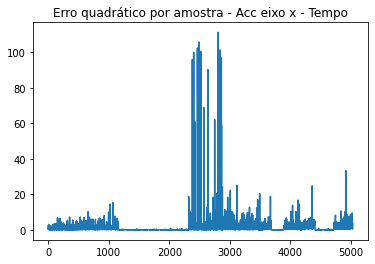

In [59]:
plt.plot(acc['x'])
plt.title('Erro quadrático por amostra - Acc eixo x - Tempo')

Text(0.5, 1.0, 'Erro quadrático por amostra - Acc eixo y - Tempo')

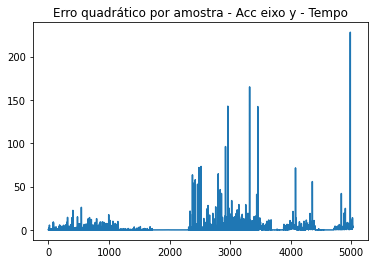

In [60]:
plt.plot(acc['y'])
plt.title('Erro quadrático por amostra - Acc eixo y - Tempo')

Text(0.5, 1.0, 'Erro quadrático por amostra - Acc eixo z - Tempo')

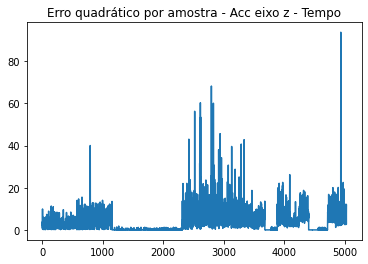

In [61]:
plt.plot(acc['z'])
plt.title('Erro quadrático por amostra - Acc eixo z - Tempo')

In [62]:
err = []
for i in range(len(acc['x'])):
    if acc['x'][i] >=60:
        err.append(i)
err

[2379,
 2401,
 2425,
 2463,
 2487,
 2518,
 2567,
 2636,
 2748,
 2803,
 2805,
 2807,
 2837,
 2858]

## Frequência

In [63]:
data_1 = data_filtered_fft.X
data_2 = data_no_gravity_fft.X

acc = {'x': [], 'y': [], 'z': []}
axis = ['x', 'y', 'z']

data_1 = data_filtered_fft.X
data_1 = np.reshape(data_1, (data_filtered.data.shape[0], 6, 30))

data_2 = data_no_gravity_fft.X
data_2 = np.reshape(data_2, (data_filtered.data.shape[0], 6, 30))

erro_list = []

for sample_1, sample_2 in zip(data_1, data_2):
    for i in range(3):
        erro = mean_squared_error(sample_1[i], sample_2[i])
        axi = axis[i]
        acc[axi].append(erro)

Text(0.5, 1.0, 'Erro quadrático por amostra - Acc eixo x - Frequência')

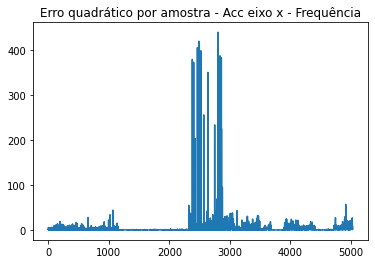

In [64]:
plt.plot(acc['x'])
plt.title('Erro quadrático por amostra - Acc eixo x - Frequência')

Text(0.5, 1.0, 'Erro quadrático por amostra - Acc eixo y - Frequência')

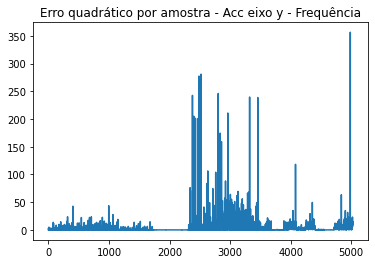

In [65]:
plt.plot(acc['y'])
plt.title('Erro quadrático por amostra - Acc eixo y - Frequência')

Text(0.5, 1.0, 'Erro quadrático por amostra - Acc eixo z - Frequência')

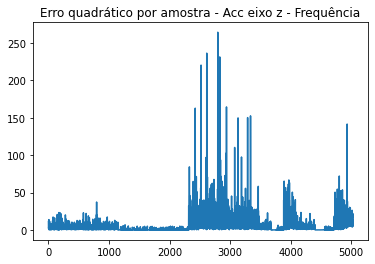

In [66]:
plt.plot(acc['z'])
plt.title('Erro quadrático por amostra - Acc eixo z - Frequência')

# Plot UMAP e T-SNE

In [67]:
def plot_data(df, figsize: tuple = (8, 8), title: str = None, labels: dict = None):
    fig, ax = plt.subplots(figsize=figsize)
    for label, group_df in df.groupby("label"):
        label = labels[label] if labels is not None else label
        ax.scatter(group_df.x, group_df.y, label=label, s=1.5)
    ax.legend()
    plt.title(title)
    plt.show()

In [68]:
def plot_classes(df, figsize: tuple = (8, 8), title: str = None, labels: dict = None):
    fig, ax = plt.subplots(figsize=figsize)
    marker = {
        "sit": '.',
        "stand": '2',
        "walk": '1',
        "stair up": '+',
        "stair down": 'x',
        "run": '4',
        "stair up and down": '3'
    }
    for label, group_df in df.groupby("label"):
        label = labels[label] if labels is not None else label
        ax.scatter(group_df.x, group_df.y, label=label, marker=marker[label])
    ax.legend()
    plt.title(title)
    plt.show()

In [29]:
standard_activity_codes = {
    0: "sit",
    1: "stand",
    2: "walk",
    3: "stair up",
    4: "stair down",
    5: "run",
    6: "stair up and down"
}
print(standard_activity_codes)

{0: 'sit', 1: 'stand', 2: 'walk', 3: 'stair up', 4: 'stair down', 5: 'run', 6: 'stair up and down'}


In [30]:
dataset = {
    'Motion_1': 'MotionSense filtered', 
    'Motion_2': 'MotionSense without gravity'
}
print(dataset)

{'Motion_1': 'MotionSense filtered', 'Motion_2': 'MotionSense without gravity'}


In [31]:
X = data_time.data.iloc[:, 540:-6]
y = np.array(data_time.data['DataSet'])
X

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,accel-z-51,accel-z-52,accel-z-53,accel-z-54,accel-z-55,accel-z-56,accel-z-57,accel-z-58,accel-z-59,activity code
0,1.013198,1.213734,2.009169,-2.182658,-2.550637,-2.970507,-0.217632,0.999594,-1.246883,-1.457703,...,0.376987,-2.081169,1.446188,-0.180460,-0.182989,0.666390,4.116260,-3.067699,-0.439384,0
1,3.468220,1.409920,-3.214915,-2.867658,-2.020174,1.271113,2.866810,3.731912,1.499058,-2.534589,...,-8.429237,-2.872219,1.445719,1.175976,1.904625,2.944915,2.950987,1.207228,0.922734,0
2,1.421498,0.017303,5.173924,-2.088614,-5.692213,-1.351758,3.589653,-0.080849,-0.191445,-0.111856,...,1.247785,2.920146,1.520683,-1.583850,-1.367630,0.809506,1.110136,0.587751,5.467525,0
3,-0.497819,1.410787,-1.164364,0.479037,3.013279,-1.456027,1.731780,0.791390,1.319055,-0.111974,...,0.378184,0.725342,0.523087,0.079355,0.776904,-1.858955,2.016718,0.997634,-1.641303,0
4,1.050593,-1.057788,-3.268201,-3.543602,-1.746914,3.277555,1.059173,2.462798,4.433639,-0.412389,...,2.839317,-1.736072,5.396047,-0.261701,1.531596,-2.827182,3.128759,0.924363,-0.535934,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5023,1.229652,3.273590,0.795043,8.451653,7.285570,-1.700821,2.379763,-0.442292,3.437822,-0.087031,...,1.391823,5.416033,9.304215,-2.585571,-5.028007,5.940004,6.213244,0.679169,-5.131871,5
5024,0.649214,1.476657,5.587020,-1.936038,0.535497,-7.897102,7.882700,-3.454315,-0.332340,-8.909386,...,5.801685,-6.414830,3.451078,12.422158,14.207994,-12.381934,7.677811,-0.169483,4.894647,5
5025,0.471196,0.730347,-9.547672,0.448438,2.080617,-0.905029,0.972964,1.209240,-6.693453,-5.028750,...,-11.683926,7.022427,10.885024,13.697942,-11.884998,-11.738040,-11.542589,-6.715729,-8.820428,5
5026,1.874669,0.951728,-0.185146,0.550318,-4.778107,2.917659,-0.018703,-2.513947,-3.151960,-0.876959,...,-4.757201,21.497997,5.864611,-9.778836,6.847781,-6.002221,2.057076,-12.224838,-3.564278,5


In [32]:
X_class = data_time_class.data.iloc[:, 540:-6]
y_class = np.array(data_time_class.data['standard activity code'])
X_class

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,accel-z-51,accel-z-52,accel-z-53,accel-z-54,accel-z-55,accel-z-56,accel-z-57,accel-z-58,accel-z-59,activity code
0,1.013198,1.213734,2.009169,-2.182658,-2.550637,-2.970507,-0.217632,0.999594,-1.246883,-1.457703,...,0.376987,-2.081169,1.446188,-0.180460,-0.182989,0.666390,4.116260,-3.067699,-0.439384,0
1,3.468220,1.409920,-3.214915,-2.867658,-2.020174,1.271113,2.866810,3.731912,1.499058,-2.534589,...,-8.429237,-2.872219,1.445719,1.175976,1.904625,2.944915,2.950987,1.207228,0.922734,0
2,1.421498,0.017303,5.173924,-2.088614,-5.692213,-1.351758,3.589653,-0.080849,-0.191445,-0.111856,...,1.247785,2.920146,1.520683,-1.583850,-1.367630,0.809506,1.110136,0.587751,5.467525,0
3,-0.497819,1.410787,-1.164364,0.479037,3.013279,-1.456027,1.731780,0.791390,1.319055,-0.111974,...,0.378184,0.725342,0.523087,0.079355,0.776904,-1.858955,2.016718,0.997634,-1.641303,0
4,1.050593,-1.057788,-3.268201,-3.543602,-1.746914,3.277555,1.059173,2.462798,4.433639,-0.412389,...,2.839317,-1.736072,5.396047,-0.261701,1.531596,-2.827182,3.128759,0.924363,-0.535934,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5023,1.229652,3.273590,0.795043,8.451653,7.285570,-1.700821,2.379763,-0.442292,3.437822,-0.087031,...,1.391823,5.416033,9.304215,-2.585571,-5.028007,5.940004,6.213244,0.679169,-5.131871,5
5024,0.649214,1.476657,5.587020,-1.936038,0.535497,-7.897102,7.882700,-3.454315,-0.332340,-8.909386,...,5.801685,-6.414830,3.451078,12.422158,14.207994,-12.381934,7.677811,-0.169483,4.894647,5
5025,0.471196,0.730347,-9.547672,0.448438,2.080617,-0.905029,0.972964,1.209240,-6.693453,-5.028750,...,-11.683926,7.022427,10.885024,13.697942,-11.884998,-11.738040,-11.542589,-6.715729,-8.820428,5
5026,1.874669,0.951728,-0.185146,0.550318,-4.778107,2.917659,-0.018703,-2.513947,-3.151960,-0.876959,...,-4.757201,21.497997,5.864611,-9.778836,6.847781,-6.002221,2.057076,-12.224838,-3.564278,5


In [33]:
data_fft = transformer(data_time)
data_fft_class = transformer(data_time_class)

### UMAP

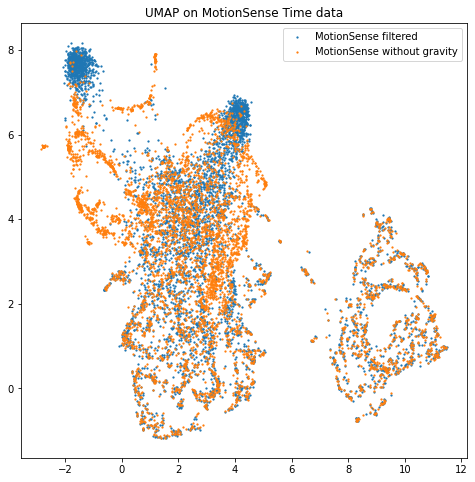

In [34]:
model = UMAP(n_components=2, random_state=0)
result = pd.DataFrame(model.fit_transform(X), columns=["x", "y"])
result["label"] = y
plot_data(result, title="UMAP on MotionSense Time data", labels=dataset)

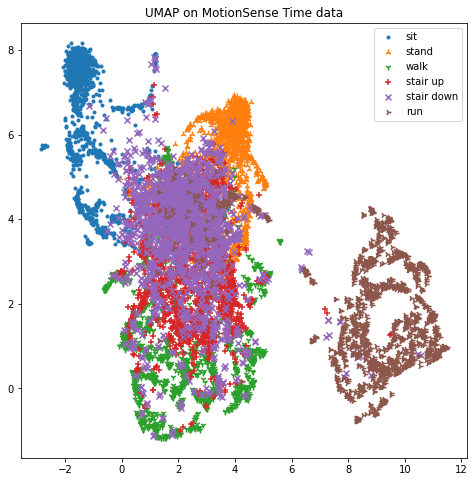

In [35]:
model = UMAP(n_components=2, random_state=0)
result = pd.DataFrame(model.fit_transform(X_class), columns=["x", "y"])
result["label"] = y_class
plot_classes(result, title="UMAP on MotionSense Time data", labels=standard_activity_codes)

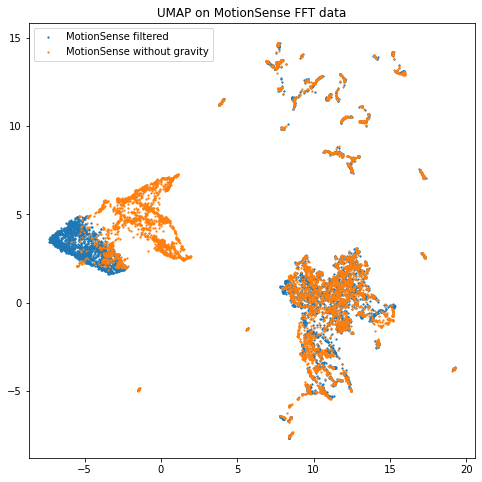

In [36]:
model = UMAP(n_components=2, random_state=0)
result = pd.DataFrame(model.fit_transform(data_fft[:][0]), columns=["x", "y"])
result["label"] = data_fft[:][1]
plot_data(result, title="UMAP on MotionSense FFT data", labels=dataset)

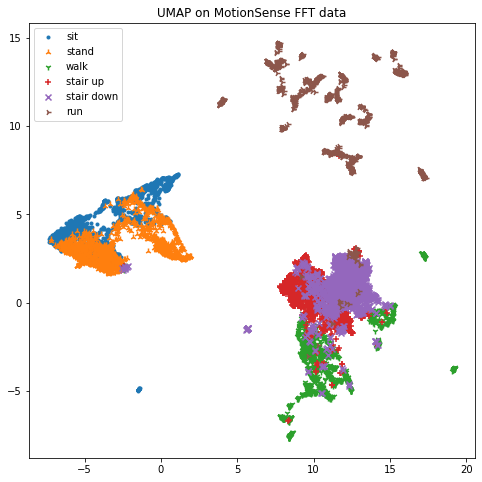

In [37]:
model = UMAP(n_components=2, random_state=0)
result = pd.DataFrame(model.fit_transform(data_fft_class[:][0]), columns=["x", "y"])
result["label"] = data_fft_class[:][1]
plot_classes(result, title="UMAP on MotionSense FFT data", labels=standard_activity_codes)

### T-SNE

/home/ic-unicamp/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ic-unicamp/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


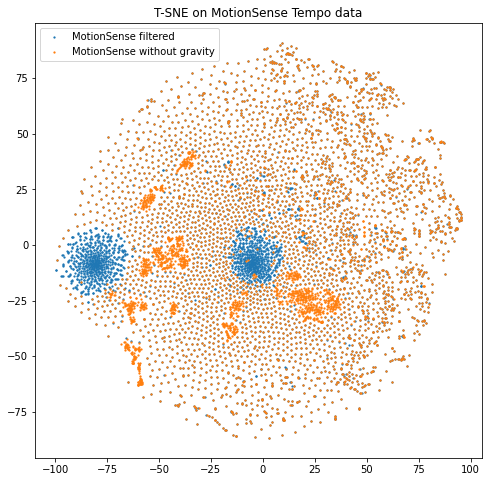

In [38]:
model = TSNE(n_components=2, random_state=0)
result = pd.DataFrame(model.fit_transform(X), columns=["x", "y"])
result["label"] = y
plot_data(result, title="T-SNE on MotionSense Tempo data", labels=dataset)

/home/ic-unicamp/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ic-unicamp/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


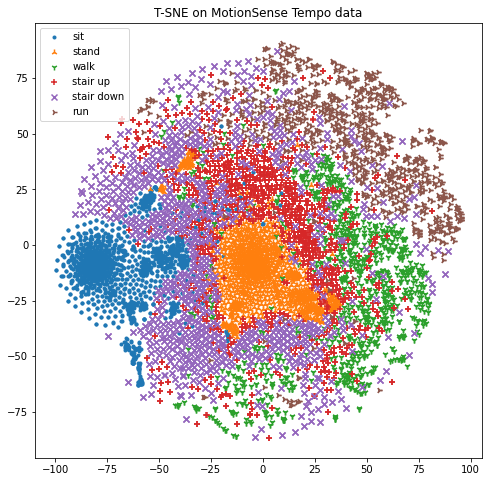

In [39]:
model = TSNE(n_components=2, random_state=0)
result = pd.DataFrame(model.fit_transform(X_class), columns=["x", "y"])
result["label"] = y_class
plot_classes(result, title="T-SNE on MotionSense Tempo data", labels=standard_activity_codes)

/home/ic-unicamp/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ic-unicamp/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


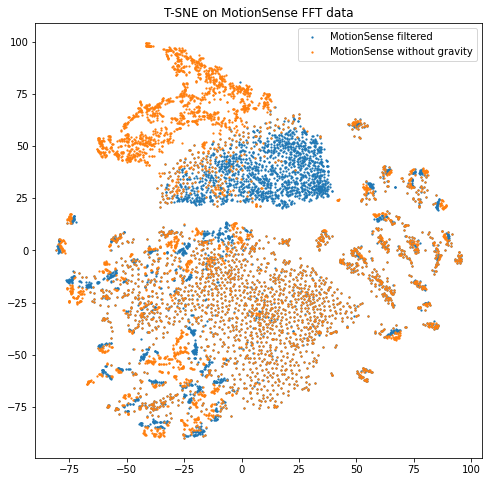

In [40]:
model = TSNE(n_components=2, random_state=0)
result = pd.DataFrame(model.fit_transform(data_fft[:][0]), columns=["x", "y"])
result["label"] = data_fft[:][1]
plot_data(result, title="T-SNE on MotionSense FFT data", labels=dataset)

/home/ic-unicamp/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ic-unicamp/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


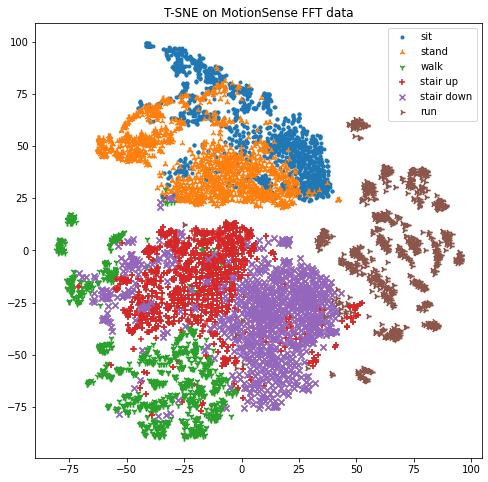

In [41]:
model = TSNE(n_components=2, random_state=0)
result = pd.DataFrame(model.fit_transform(data_fft_class[:][0]), columns=["x", "y"])
result["label"] = data_fft_class[:][1]
plot_classes(result, title="T-SNE on MotionSense FFT data", labels=standard_activity_codes)